<a href="https://colab.research.google.com/github/truthofmyrrh/CJ_Demand_Forecasting/blob/main/CODE/%EA%B3%A0%EA%B0%9D%EC%82%AC__%EB%B0%8F__%ED%92%88%EB%AA%A9%EB%B3%84_%EC%9D%BC%EC%9D%BC_%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (10.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155222 files and di

In [3]:
!pip uninstall plotly
!pip install plotly==3.10.0

Found existing installation: plotly 4.4.1
Uninstalling plotly-4.4.1:
  Would remove:
    /usr/local/etc/jupyter/nbconfig/notebook.d/plotlywidget.json
    /usr/local/lib/python3.7/dist-packages/_plotly_future_/*
    /usr/local/lib/python3.7/dist-packages/_plotly_utils/*
    /usr/local/lib/python3.7/dist-packages/plotly-4.4.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/plotly/*
    /usr/local/lib/python3.7/dist-packages/plotlywidget/*
    /usr/local/share/jupyter/nbextensions/plotlywidget/extension.js
    /usr/local/share/jupyter/nbextensions/plotlywidget/index.js
Proceed (y/n)? y
  Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 41.5 MB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cufflinks 0.17.3 requires plotly>=4.1.1, but you have plotly 3.10.0 which is incompatible.


## 01) 라이브러리 및 데이터 불러오기

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumBarunGothic') 

from datetime import datetime
import time

from IPython.display import Image

from collections import Counter

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

import tensorflow as tf
from numpy.random import seed
tf.random.set_seed(123)
seed(123)

In [ ]:
# 데이터 불러오기
mon3 = pd.read_csv('/content/drive/MyDrive/졸업프젝/예측 모델링/Data/3월.csv',encoding='cp949')
mon4 = pd.read_csv('/content/drive/MyDrive/졸업프젝/예측 모델링/Data/4월.csv',encoding='cp949')
mon5 = pd.read_csv('/content/drive/MyDrive/졸업프젝/예측 모델링/Data/5월.csv',encoding='cp949')
mon6 = pd.read_csv('/content/drive/MyDrive/졸업프젝/예측 모델링/Data/6월.csv',encoding='cp949')
df_order = pd.concat([mon3,mon4,mon5,mon6])
df_order.reset_index(drop=True,inplace=True)

# 데이터 확인
pd.options.display.float_format = '{:.0f}'.format # 과학적 표기법 사용하지 않음
df_order.head(5)

,CORP_ID,REF_ORD_NO,BKG_NO,BKG_TYP,BKG_DATE,BKG_TIME,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,BRAND_NM,ITEM_QTY,ITEM_AMT,IF_YN,ORDER_CRT_DATETIME,DLV_DV,REF_ITEM_SEQ,ORDER_IDX,ORDER_YN,DLVPREARRBRANCD,DLVPREARREMPNICKNM,DLVCLSFCD,DLVSUBCLSFCD,INS_ID,INS_DATE,INS_TIME,POST_ZONE,SPLIT_EXEC_YN,SHPR_ADDR_1,SHPR_ADDR_2,CNEE_ADDR_1,CNEE_ADDR_2
0,KX007,2021030365922550,KX007210303370934,7,20210303,35510,90001302,22400,2,134265392,단일상품,1,14900,N,20210303035459,1,2021030323885040,2021030323885040,Y,7484,C06,5Z73,1,iNEXBatch,20210303,131425,3,N,세종특별자치시,NaN,서울특별시,서대문구
1,KX007,2021030365922950,KX007210303371080,7,20210303,35521,90001441,20900,1,4610261043_2,조합형옵션상품,1,20900,N,20210303035501,1,2021030323885720,2021030323885720,Y,6427,M09,6R67,4,iNEXBatch,20210303,131425,50,N,경기도,광주시,경상남도,김해시
2,KX007,2021030365924360,KX007210303371081,7,20210303,35513,90001441,37900,1,4936599538_1,조합형옵션상품,1,37900,N,20210303035505,1,2021030323887980,2021030323887980,Y,6158,L32,9Y25,0,iNEXBatch,20210303,131425,53,N,경기도,광주시,경상남도,거제시
3,KX007,2021030365928920,KX007210303371205,7,20210303,35608,90001542,69800,1,3858391637_1,조합형옵션상품,1,69800,N,20210303035519,1,2021030323895280,2021030323895280,Y,8909,D21,1N65,1,iNEXBatch,20210303,131425,6,N,경기도,광주시,서울특별시,서초구
4,KX007,2021030365930450,KX007210303370967,7,20210303,35551,90001341,73700,1,4631307460,단일상품,1,39800,N,20210303035524,1,2021030323897650,2021030323897650,Y,2777,R15,3D84,1,iNEXBatch,20210303,131425,10,N,경기도,광주시,경기도,김포시


In [ ]:
# 열 확인
df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786374 entries, 0 to 1786373
Data columns (total 32 columns):
 #   Column              Dtype  
---  ------              -----  
 0   CORP_ID             object 
 1   REF_ORD_NO          object 
 2   BKG_NO              object 
 3   BKG_TYP             int64  
 4   BKG_DATE            int64  
 5   BKG_TIME            int64  
 6   SHPR_CD             int64  
 7   INV_AMT             float64
 8   ITEM_SEQ            int64  
 9   ITEM_CD             object 
 10  BRAND_NM            object 
 11  ITEM_QTY            int64  
 12  ITEM_AMT            float64
 13  IF_YN               object 
 14  ORDER_CRT_DATETIME  float64
 15  DLV_DV              float64
 16  REF_ITEM_SEQ        object 
 17  ORDER_IDX           object 
 18  ORDER_YN            object 
 19  DLVPREARRBRANCD     object 
 20  DLVPREARREMPNICKNM  object 
 21  DLVCLSFCD           object 
 22  DLVSUBCLSFCD        object 
 23  INS_ID              object 
 24  INS_DATE            int6

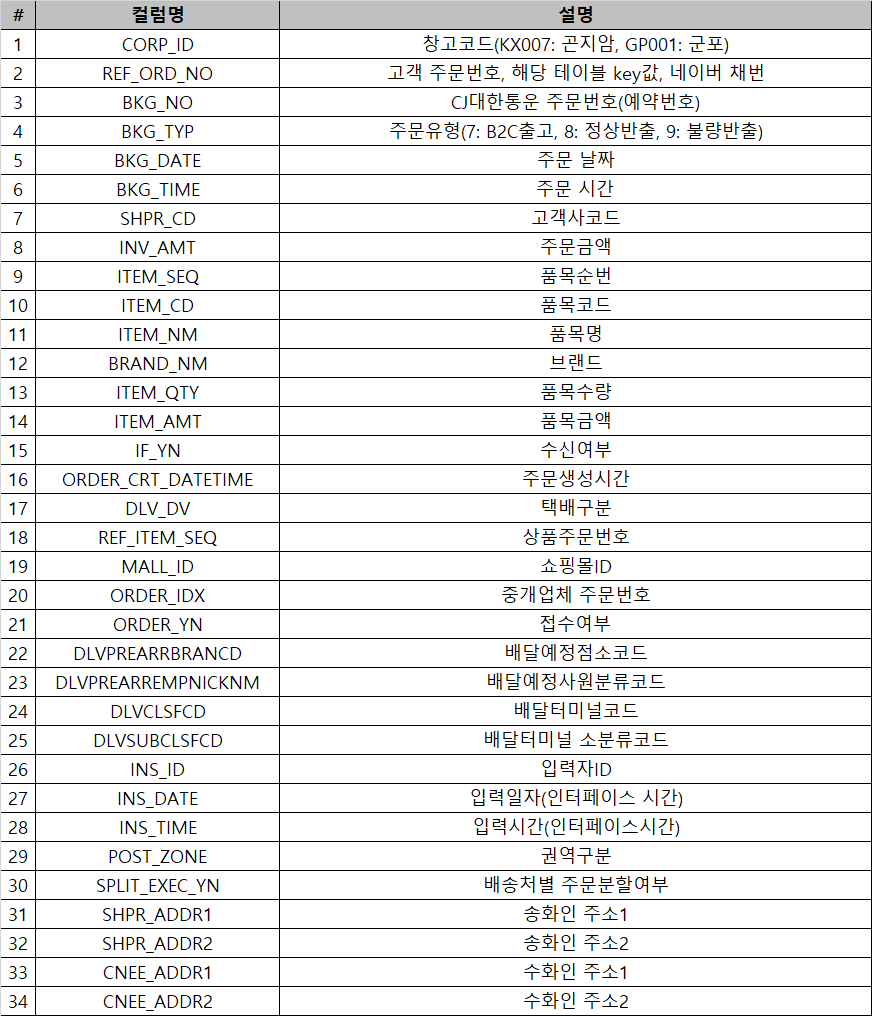

In [ ]:
# 데이터 정의서 불러오기
Image("/content/drive/MyDrive/졸업프젝/예측 모델링/Data/컬럼설명.png")

In [ ]:
# 형 변환
for i in range(len(df_order.columns)):
  if df_order.columns[i] != "INV_AMT" and df_order.columns[i] != "ITEM_AMT":
    df_order.iloc[:,[i]] = df_order.iloc[:,[i]].astype("string")

# 데이터 타입 확인
print(df_order.dtypes)

CORP_ID                string
REF_ORD_NO             string
BKG_NO                 string
BKG_TYP                string
BKG_DATE               string
BKG_TIME               string
SHPR_CD                string
INV_AMT               float64
ITEM_SEQ               string
ITEM_CD                string
BRAND_NM               string
ITEM_QTY               string
ITEM_AMT              float64
IF_YN                  string
ORDER_CRT_DATETIME     string
DLV_DV                 string
REF_ITEM_SEQ           string
ORDER_IDX              string
ORDER_YN               string
DLVPREARRBRANCD        string
DLVPREARREMPNICKNM     string
DLVCLSFCD              string
DLVSUBCLSFCD           string
INS_ID                 string
INS_DATE               string
INS_TIME               string
POST_ZONE              string
SPLIT_EXEC_YN          string
SHPR_ADDR_1            string
SHPR_ADDR_2            string
CNEE_ADDR_1            string
CNEE_ADDR_2            string
dtype: object


## 02) 필요한 행, 열 추출

In [ ]:
# 수요 예측에 필요없는 열 제거
df_order_select = df_order.drop(['CORP_ID','IF_YN','DLV_DV','ORDER_YN','DLVPREARRBRANCD','DLVPREARREMPNICKNM','DLVCLSFCD','DLVSUBCLSFCD',
                          'ORDER_IDX','INS_ID','POST_ZONE','SPLIT_EXEC_YN','SHPR_ADDR_1','SHPR_ADDR_2','CNEE_ADDR_2'],axis=1)
# 수요 예측에 필요없는 행 제거
df_order_select = df_order_select[df_order_select['BKG_TYP']=="7"]
df_order_select.reset_index(drop=True,inplace=True)

## 03) 결측값 처리

In [ ]:
# 결측값 확인
df_order_select.isnull().sum()

REF_ORD_NO                0
BKG_NO                    9
BKG_TYP                   0
BKG_DATE                  0
BKG_TIME                  0
SHPR_CD                   0
INV_AMT               26964
ITEM_SEQ                  0
ITEM_CD                   0
BRAND_NM              40912
ITEM_QTY                  0
ITEM_AMT              17842
ORDER_CRT_DATETIME    40914
REF_ITEM_SEQ           1000
INS_DATE                  0
INS_TIME                  0
CNEE_ADDR_1               7
dtype: int64

In [ ]:
# 결측값이 존재하는 행 개수
print("전체 행 개수 = " +str(len(df_order_select)))
print("결측값이 존재하는 행 개수 = "+ str(len(df_order_select) - len(df_order_select.dropna(axis=0))))
print("결측행 비율 = "+str(round((len(df_order_select) - len(df_order_select.dropna(axis=0)))/len(df_order_select)*100,1))+"%")

전체 행 개수 = 1785327
결측값이 존재하는 행 개수 = 40930
결측행 비율 = 2.3%


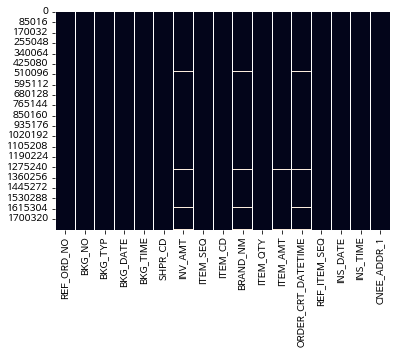

In [ ]:
# 결측값 시각화 -> 분포 확인
%matplotlib inline
sns.heatmap(df_order_select.isnull(),cbar=False)

In [ ]:
# 주문번호 결측 행 확인
df_order_select[df_order_select.BKG_NO.isnull()]

,REF_ORD_NO,BKG_NO,BKG_TYP,BKG_DATE,BKG_TIME,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,BRAND_NM,ITEM_QTY,ITEM_AMT,ORDER_CRT_DATETIME,REF_ITEM_SEQ,INS_DATE,INS_TIME,CNEE_ADDR_1
60393,2021030526102510,<NA>,7,20210305,145647,90001441,34900,1,4762674514,조합형옵션상품,2,27800,20210305145640.0,2021030518007450,20210306,1426,부산광역시
60395,2021030526102510,<NA>,7,20210305,145647,90001441,34900,2,2475138283,단일상품,1,15900,20210305145640.0,2021030518007460,20210306,1426,부산광역시
60397,2021030526102510,<NA>,7,20210305,145647,90001441,34900,3,3667604580,단일상품,1,20900,20210305145640.0,2021030518007470,20210306,1426,부산광역시
344621,2021040552039810,<NA>,7,20210405,44640,90001341,31800,1,2194762776_61,조합형옵션상품,1,39900,20210405044617.0,2021040565736240,20210405,140128,충청북도
710909,2021050728395860,<NA>,7,20210506,154036,90001521,59600,1,4824189340_7,조합형옵션상품,1,126800,20210506154028.0,2021050793493430,20210507,5628,전라남도
1085063,2021052982668600,<NA>,7,20210529,22512,90001341,17900,1,4568271030_31,조합형옵션상품,1,19900,20210529022441.0,2021052969291660,20210529,114251,서울특별시
1320155,2021061047749110,<NA>,7,20210609,170846,90001542,133800,1,4597019110,단일상품,1,14900,20210609170840.0,2021061013941790,20210610,22209,경기도
1433055,2021061288586830,<NA>,7,20210612,15355,90001302,18900,1,5611763326_1,조합형옵션상품,1,20900,20210612015349.0,2021061281730470,20210612,110237,전라남도
1546094,2021061942335490,<NA>,7,20210619,12534,90001602,48900,1,5034005041,단일상품,1,79000,20210619012519.0,2021061933938190,20210619,104230,부산광역시


In [ ]:
# 고객 주문번호(REF_ORD_NO)가 같으면 대한통운 주문번호(BKG_NO)도 같다
df_order_select[df_order_select['REF_ORD_NO'] == df_order_select[df_order_select.BKG_NO.isnull()]['REF_ORD_NO'].tolist()[0]]

,REF_ORD_NO,BKG_NO,BKG_TYP,BKG_DATE,BKG_TIME,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,BRAND_NM,ITEM_QTY,ITEM_AMT,ORDER_CRT_DATETIME,REF_ITEM_SEQ,INS_DATE,INS_TIME,CNEE_ADDR_1
60393,2021030526102510,<NA>,7,20210305,145647,90001441,34900,1,4762674514,조합형옵션상품,2,27800,20210305145640.0,2021030518007450,20210306,1426,부산광역시
60394,2021030526102510,KX007210308424486,7,20210305,145647,90001341,64600,1,4762674514,조합형옵션상품,2,27800,20210305145640.0,2021030518007450,20210306,1426,부산광역시
60395,2021030526102510,<NA>,7,20210305,145647,90001441,34900,2,2475138283,단일상품,1,15900,20210305145640.0,2021030518007460,20210306,1426,부산광역시
60396,2021030526102510,KX007210308424486,7,20210305,145647,90001341,64600,2,2475138283,단일상품,1,15900,20210305145640.0,2021030518007460,20210306,1426,부산광역시
60397,2021030526102510,<NA>,7,20210305,145647,90001441,34900,3,3667604580,단일상품,1,20900,20210305145640.0,2021030518007470,20210306,1426,부산광역시
60398,2021030526102510,KX007210308424486,7,20210305,145647,90001341,64600,3,3667604580,단일상품,1,20900,20210305145640.0,2021030518007470,20210306,1426,부산광역시


In [ ]:
# REF_ORD_NO가 같을 경우 같은 주문이므로 동일힌 BKG_NO 값 넣어주기
ord_no=df_order_select[df_order_select.BKG_NO.isnull()]['REF_ORD_NO'].unique()

for i in range(0,len(ord_no)):
    arr_bkg_no = df_order_select[df_order_select['REF_ORD_NO'] == ord_no[i]]['BKG_NO'].unique()
    if len(arr_bkg_no) == 2:
        ind = df_order_select[df_order_select['REF_ORD_NO'] == ord_no[i]].index
        for j in range(0,len(ind)):
            df_order_select.iloc[[ind[j]],[1]] = arr_bkg_no.dropna()[0]
    else:
        print("결측치 확인")
        print(ord_no[i])
        break;

In [ ]:
df_order_select[df_order_select.BKG_NO.isnull()]

,REF_ORD_NO,BKG_NO,BKG_TYP,BKG_DATE,BKG_TIME,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,BRAND_NM,ITEM_QTY,ITEM_AMT,ORDER_CRT_DATETIME,REF_ITEM_SEQ,INS_DATE,INS_TIME,CNEE_ADDR_1


In [ ]:
# CNEE_ADDR_1 결측 행 확인 -> BRAND_NM열과 동시에 결측 발생
df_order_select[df_order_select.CNEE_ADDR_1.isnull()]

,REF_ORD_NO,BKG_NO,BKG_TYP,BKG_DATE,BKG_TIME,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,BRAND_NM,ITEM_QTY,ITEM_AMT,ORDER_CRT_DATETIME,REF_ITEM_SEQ,INS_DATE,INS_TIME,CNEE_ADDR_1
91868,2021031141088781_C538,KX007210311470217,7,20210311,162116,90001542,nan,1,8809514641950,<NA>,3,235000,<NA>,8809514641950,20210311,162116,<NA>
1529278,2021053138048361_C026_C098,KX007210621387589,7,20210621,150355,90001443,nan,1,6079851,<NA>,3,38700,<NA>,2021053154547990,20210621,150355,<NA>
1529279,2021053138048361_C026_C098,KX007210621387589,7,20210621,150355,90001443,nan,2,6081398,<NA>,1,3500,<NA>,2021053154547960,20210621,150355,<NA>
1529280,2021053138048361_C026_C098,KX007210621387589,7,20210621,150355,90001443,nan,3,6092762,<NA>,1,3900,<NA>,2021053154547950,20210621,150355,<NA>
1529963,2021053138048361_C026_C098,KX007210621387589,7,20210621,150355,90001443,nan,4,6098874,<NA>,1,6900,<NA>,2021053154547970,20210621,150355,<NA>
1534597,2021062060572840,GP001210623445114,7,20210620,64459,90001705,336000,1,shop0001177,조합형옵션상품,1,168000,20210620064451.0,2021062063387100,20210620,154931,<NA>
1649223,2021062832785740,GP001210701657752,7,20210628,124336,90001768,122000,1,4748857542_4,조합형옵션상품,1,61000,20210628124315.0,2021062847403990,20210628,124935,<NA>


결측값 비율 크지 않고 한 행에 동시 존재 -> 행 삭제가 적합함

In [ ]:
df_order_complete = df_order_select.dropna(axis=0) # 결측값이 있는 행(40,921개) 제거
df_order_complete.reset_index(drop=True,inplace=True)
df_order_complete.tail(5)

,REF_ORD_NO,BKG_NO,BKG_TYP,BKG_DATE,BKG_TIME,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,BRAND_NM,ITEM_QTY,ITEM_AMT,ORDER_CRT_DATETIME,REF_ITEM_SEQ,INS_DATE,INS_TIME,CNEE_ADDR_1
1744401,2021063088148030,GP001210702672138,7,20210630,233214,90001776,24000,1,4782863820,단일상품,2,24000,20210630233158.0,2021063049623360,20210702,104248,서울특별시
1744402,2021063073024910,GP001210703686543,7,20210630,104020,90001776,200000,1,2055189125,단일상품,2,200000,20210630104010.0,2021063024476020,20210702,232200,부산광역시
1744403,2021063087455440,GP001210704726193,7,20210630,225653,90001842,77000,1,4891818594_1,조합형옵션상품,2,77000,20210630225649.0,2021063048425020,20210703,234925,경상남도
1744404,2021062966256440,KX007210703687487,7,20210629,223503,90001622,125800,1,5525868431,단일상품,2,125800,20210629223458.0,2021062912992740,20210703,1424,부산광역시
1744405,2021063082592750,KX007210702676859,7,20210630,183014,90001302,52000,1,5054805158_25,조합형옵션상품,1,52000,20210630183007.0,2021063040568290,20210702,141424,인천광역시


## 04) 데이터 전처리
- 주소: 'CNEE_ADDR_1'  
        ['서울', '경남', '경기', '부산', '대전', '전북', '충남', '경북', '인천', '강원', '전남','대구', '세종', '충북', '울산', '광주', '제주']
  ↳ 해당 값으로 데이터 분류  

- 날짜 및 시간:  
    (1) 'ORDER_CRT_DATETIME': 주문 생성 시간  
    (2) 'BKG_DATE', 'BKG_TIME': 주문 시간  
    (3) 'INS_DATE', 'INS_TIME': 입력 시간  

    가장 최초에 발생하는 주문 생성 시간(1)을 기준하여,  
    (2)-(1)=지연시간1(초 단위), (3)-(2)=지연시간2(초 단위) 로 설정

In [ ]:
# 주소 데이터 확인
df_order_complete['CNEE_ADDR_1'].unique()

<StringArray>
[                     '서울특별시',                       '경상남도',
                        '경기도',                      '부산광역시',
                      '대전광역시',                       '전라북도',
                       '충청남도',                       '경상북도',
                      '인천광역시',                        '강원도',
                       '전라남도',                      '대구광역시',
                    '세종특별자치시',                       '충청북도',
                      '울산광역시',                      '광주광역시',
                    '제주특별자치도',                         '강원',
                         '서울',                         '경기',
                         '경북',                         '대전',
                         '광주',                         '전북',
                         '경남',                         '대구',
                         '인천',                         '전남',
                         '부산',                         '충남',
                         '충북',                         '울산',
          

In [ ]:
# 주소 형식 지정
change_value = { "서울특별시" : "서울", "경상남도" : "경남", "경기도" : "경기", "부산광역시" : "부산", "대전광역시": "대전", "전라북도" : "전북", 
                 "충청남도" : "충남", "경상북도" : "경북", "인천광역시" : "인천", "강원도" : "강원", "전라남도" : "전남", "대구광역시" : "대구",
                 "세종특별자치시" : "세종", "충청북도" : "충북", "울산광역시" : "울산", "광주광역시" : "광주", "제주특별자치도" : "제주", "道路名稱首爾特別市中區麻將路1街22號（STUDIO" : "서울",
                 "인천시" : "인천", "대구시" : "대구", "마포구" : "서울", "부산시" : "부산", "영천시" : "경북", "인천광역시미추홀구" : "인천"}

df_order_complete = df_order_complete.replace({ "CNEE_ADDR_1" : change_value})

In [ ]:
df_order_complete['CNEE_ADDR_1'].unique()

array(['서울', '경남', '경기', '부산', '대전', '전북', '충남', '경북', '인천', '강원', '전남',
       '대구', '세종', '충북', '울산', '광주', '제주'], dtype=object)

In [ ]:
# 문자열 소수점 버리기
df_order_complete['ORDER_CRT_DATETIME']= df_order_complete['ORDER_CRT_DATETIME'].str.slice(start=0, stop=14)

In [ ]:
from collections import Counter
# 문자열 길이 세기
crt_time_len = []
bgk_time_len = []
ins_time_len = []

for i in range(0,len(df_order_complete)):
    crt_time_len.append(len(df_order_complete['ORDER_CRT_DATETIME'][i]))
    bgk_time_len.append(len(df_order_complete['BKG_TIME'][i]))
    ins_time_len.append(len(df_order_complete['INS_TIME'][i]))

print("ORDER_CRT_DATETIME 문자열 길이")
print(Counter(crt_time_len))
print("BKG_TIME 문자열 길이")
print(Counter(bgk_time_len))
print("INS_TIME 문자열 길이")
print(Counter(ins_time_len))
# BKG_TIME, INS_TIME 길이가 6자리로 일정하지 않음 -> 시간/날짜 앞의 0 생략됨

ORDER_CRT_DATETIME 문자열 길이
Counter({14: 1744406})
BKG_TIME 문자열 길이
Counter({6: 857337, 5: 798113, 4: 75458, 3: 12189, 2: 1095, 1: 214})
INS_TIME 문자열 길이
Counter({6: 1360469, 5: 314775, 4: 57809, 3: 11353})


In [ ]:
for i in range(0,len(df_order_complete)) :
    while (len(df_order_complete['BKG_TIME'][i]) < 6):
        df_order_complete['BKG_TIME'][i] = '0' + df_order_complete['BKG_TIME'][i]

    while (len(df_order_complete['INS_TIME'][i]) < 6):
        df_order_complete['INS_TIME'][i] = '0' + df_order_complete['INS_TIME'][i]


# 길이 6자리로 일정한지 확인
bgk_time_len = []
ins_time_len = []

for i in range(0,len(df_order_complete)):
    bgk_time_len.append(len(df_order_complete['BKG_TIME'][i]))
    ins_time_len.append(len(df_order_complete['INS_TIME'][i]))
    
print("BKG_TIME 문자열 길이")
print(Counter(bgk_time_len))
print("INS_TIME 문자열 길이")
print(Counter(ins_time_len))

BKG_TIME 문자열 길이
Counter({6: 1744406})
INS_TIME 문자열 길이
Counter({6: 1744406})


In [ ]:
# 날짜+시간 합치기
df_order_complete['BKG'] = df_order_complete[['BKG_DATE','BKG_TIME']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df_order_complete['INS'] = df_order_complete[['INS_DATE','INS_TIME']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# 단계별 지연 시간 계산을 위해 날짜 형식으로 변환
df_order_complete["ORDER_CRT"] = df_order_complete['ORDER_CRT_DATETIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d%H%M%S'))
df_order_complete['BKG'] = df_order_complete['BKG'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d %H%M%S'))
df_order_complete['INS'] = df_order_complete['INS'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d %H%M%S'))

# 지연 시간(초) 데이터 추가
df_order_complete['ORDER_CRT_BKG'] = (df_order_complete['BKG']-df_order_complete['ORDER_CRT']).apply(lambda x: x.seconds)
df_order_complete['BKG_INS'] = (df_order_complete['INS']-df_order_complete['BKG']).apply(lambda x: x.seconds)

# 주문 생성 날짜, 시간 구분
df_order_complete['ORDER_CRT_TIME'] = df_order_complete['ORDER_CRT']
df_order_complete['ORDER_CRT_DATE'] = df_order_complete["ORDER_CRT"].apply(lambda x: '{:04}-{:02}-{:02}'.format(x.year,x.month,x.day))

In [ ]:
# 결과 확인
df_order_complete[['ORDER_CRT_DATE','ORDER_CRT_TIME','ORDER_CRT_BKG','BKG_INS']]

,ORDER_CRT_DATE,ORDER_CRT_TIME,ORDER_CRT_BKG,BKG_INS
0,2021-03-03,2021-03-03 03:54:59,11,33555
1,2021-03-03,2021-03-03 03:55:01,20,33544
2,2021-03-03,2021-03-03 03:55:05,8,33552
3,2021-03-03,2021-03-03 03:55:19,49,33497
4,2021-03-03,2021-03-03 03:55:24,27,33514
...,...,...,...,...
1744401,2021-06-30,2021-06-30 23:31:58,16,40234
1744402,2021-06-30,2021-06-30 10:40:10,10,45700
1744403,2021-06-30,2021-06-30 22:56:49,4,3152
1744404,2021-06-29,2021-06-29 22:34:58,5,5961


In [ ]:
# 필요 없는 열 버리기
df_order_complete = df_order_complete[['BKG_NO','SHPR_CD','INV_AMT','ITEM_SEQ','ITEM_CD','ITEM_QTY','ITEM_AMT','BRAND_NM','ORDER_CRT_DATE','ORDER_CRT_TIME','ORDER_CRT_BKG','BKG_INS','CNEE_ADDR_1']]
df_order_complete.tail(5)

,BKG_NO,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,ITEM_QTY,ITEM_AMT,BRAND_NM,ORDER_CRT_DATE,ORDER_CRT_TIME,ORDER_CRT_BKG,BKG_INS,CNEE_ADDR_1
1744401,GP001210702672138,90001776,24000,1,4782863820,2,24000,단일상품,2021-06-30,2021-06-30 23:31:58,16,40234,서울
1744402,GP001210703686543,90001776,200000,1,2055189125,2,200000,단일상품,2021-06-30,2021-06-30 10:40:10,10,45700,부산
1744403,GP001210704726193,90001842,77000,1,4891818594_1,2,77000,조합형옵션상품,2021-06-30,2021-06-30 22:56:49,4,3152,경남
1744404,KX007210703687487,90001622,125800,1,5525868431,2,125800,단일상품,2021-06-29,2021-06-29 22:34:58,5,5961,부산
1744405,KX007210702676859,90001302,52000,1,5054805158_25,1,52000,조합형옵션상품,2021-06-30,2021-06-30 18:30:07,7,71050,인천


In [ ]:
# 백업
df_order_complete.to_csv("/content/drive/MyDrive/졸업프젝/예측 모델링/Data/df_order_complete.csv",encoding='cp949')

## 05) 외부 데이터와 결합
- df_holiday: 공휴일 데이터
- df_week: 요일 데이터
- df_weather: 기온 데이터
- df_covid: 코로나 확진자 데이터

-> 전처리 후, 시간 및 지역을 기준으로 merge

In [ ]:
# 수집한 데이터 불러오기
df_holiday = pd.read_csv('/content/drive/MyDrive/졸업프젝/예측 모델링/Data/공휴일데이터.csv',encoding='cp949', usecols= ['날짜','명칭','휴일여부'])
df_week = pd.read_csv('/content/drive/MyDrive/졸업프젝/예측 모델링/Data/요일데이터.csv',encoding='cp949')
df_weather = pd.read_csv('/content/drive/MyDrive/졸업프젝/예측 모델링/Data/시도별_기상데이터.csv',encoding='cp949', usecols=['날짜','시간','지역명','기온'])
df_covid = pd.read_csv('/content/drive/MyDrive/졸업프젝/예측 모델링/Data/시도별_코로나데이터.csv',encoding='cp949', usecols= ['기준일시', '지역', '지역발생수'])
# 데이터타입 확인
print(df_holiday.dtypes)
print(df_week.dtypes)
print(df_weather.dtypes)
print(df_covid.dtypes)

날짜      object
명칭      object
휴일여부    object
dtype: object
날짜      object
요일      object
휴일여부    object
dtype: object
날짜      object
시간       int64
지역명     object
기온     float64
dtype: object
기준일시     object
지역       object
지역발생수     int64
dtype: object


In [ ]:
# 형변환
df_holiday['날짜'] = df_holiday['날짜'].astype("string")
df_holiday['명칭'] = df_holiday['명칭'].astype("string")
df_holiday['휴일여부'] = df_holiday['휴일여부'].astype("string")

df_week['날짜'] = df_week['날짜'].astype("string")
df_week['요일'] = df_week['요일'].astype("string")
df_week['휴일여부'] = df_week['휴일여부'].astype("string")

df_weather['날짜'] = df_weather['날짜'].astype("string")
df_weather['지역명'] = df_weather['지역명'].astype("string")

df_covid['기준일시'] = df_covid['기준일시'].astype("string")
df_covid['지역'] = df_covid['지역'].astype("string")

In [ ]:
# 결측값 확인
print(df_holiday.isnull().sum())
print(df_week.isnull().sum())
print(df_weather.isnull().sum()) # 결측치 존재
print(df_covid.isnull().sum())

날짜      0
명칭      0
휴일여부    0
dtype: int64
날짜      0
요일      0
휴일여부    0
dtype: int64
날짜     0
시간     0
지역명    0
기온     2
dtype: int64
기준일시     0
지역       0
지역발생수    0
dtype: int64


In [ ]:
df_weather[df_weather.기온.isnull()]

,날짜,시간,지역명,기온
26950,2021-04-14,23,세종,nan
26951,2021-04-15,0,세종,nan


In [ ]:
df_weather[((df_weather['날짜'] == '2021-04-14') | (df_weather['날짜'] == '2021-04-15')) & (df_weather['지역명'] == '세종')][20:30]

,날짜,시간,지역명,기온
26947,2021-04-14,20,세종,9
26948,2021-04-14,21,세종,8
26949,2021-04-14,22,세종,7
26950,2021-04-14,23,세종,nan
26951,2021-04-15,0,세종,nan
26952,2021-04-15,1,세종,5
26953,2021-04-15,2,세종,3
26954,2021-04-15,3,세종,2
26955,2021-04-15,4,세종,3
26956,2021-04-15,5,세종,2


In [ ]:
# 인근 시간대 기온으로 결측값 대체
df_weather = df_weather.fillna(((7+5)/2))
df_weather[26949:26954]

,날짜,시간,지역명,기온
26949,2021-04-14,22,세종,7
26950,2021-04-14,23,세종,6
26951,2021-04-15,0,세종,6
26952,2021-04-15,1,세종,5
26953,2021-04-15,2,세종,3


In [ ]:
# 결측값 처리 후 확인
print(df_holiday.isnull().sum())
print(df_week.isnull().sum())
print(df_weather.isnull().sum())
print(df_covid.isnull().sum())
# 결측값 없음

날짜      0
명칭      0
휴일여부    0
dtype: int64
날짜      0
요일      0
휴일여부    0
dtype: int64
날짜     0
시간     0
지역명    0
기온     0
dtype: int64
기준일시     0
지역       0
지역발생수    0
dtype: int64


전처리 과정
1. 공휴일 데이터와 요일 데이터를 합하여, 해당 기간 동안 공휴일+주말 ("Y") / 평일 ("N") 구분
2. 기온 데이터: 시간 0시 -> 이전날 24시로 바꾸기
3. 코로나 데이터: 일별 지역별 확진자 수와 확진자 수 비율 데이터 만들기

In [ ]:
# 1.
for i in range(0,len(df_holiday)):
    hyuil = df_holiday['날짜'][i]
    idx = df_week.index[df_week['날짜'] == hyuil].tolist()[0]
    df_week['휴일여부'][idx] = 'Y'
df_week

,날짜,요일,휴일여부
0,2021-02-01,월,N
1,2021-02-02,화,N
2,2021-02-03,수,N
3,2021-02-04,목,N
4,2021-02-05,금,N
...,...,...,...
145,2021-06-26,토,Y
146,2021-06-27,일,Y
147,2021-06-28,월,N
148,2021-06-29,화,N


In [ ]:
# 2.
df_weather

,날짜,시간,지역명,기온
0,2021-02-01,1,서울,6
1,2021-02-01,2,서울,6
2,2021-02-01,3,서울,6
3,2021-02-01,4,서울,6
4,2021-02-01,5,서울,6
...,...,...,...,...
61195,2021-06-30,20,제주,25
61196,2021-06-30,21,제주,24
61197,2021-06-30,22,제주,24
61198,2021-06-30,23,제주,24


In [ ]:
# 날짜 형식으로 변환
df_weather["날짜"] = df_weather["날짜"].apply(lambda x: pd.to_datetime(str(x), format = '%Y-%m-%d'))

# 0시 - > 24시 로 바꾸기
ind = df_weather[df_weather['시간'] == 0].index
for j in range(0,len(ind)):
    changDt = df_weather[df_weather['시간'] == 0]['날짜'][ind[j]] - datetime.timedelta(days=1)
    df_weather.iloc[ind[j],0] = changDt
    df_weather.iloc[ind[j],1] = 24

In [ ]:
# 다시 데이터 병합을 위해 문자열로 바꿔주기
df_weather['날짜'] = df_weather['날짜'].astype("string")

In [ ]:
df_weather

,날짜,시간,지역명,기온
0,2021-02-01,1,서울,6
1,2021-02-01,2,서울,6
2,2021-02-01,3,서울,6
3,2021-02-01,4,서울,6
4,2021-02-01,5,서울,6
...,...,...,...,...
61195,2021-06-30,20,제주,25
61196,2021-06-30,21,제주,24
61197,2021-06-30,22,제주,24
61198,2021-06-30,23,제주,24


In [ ]:
# 3.
df_covid

,기준일시,지역,지역발생수
0,2021-06-30,합계,759
1,2021-06-30,서울,368
2,2021-06-30,부산,13
3,2021-06-30,대구,11
4,2021-06-30,인천,29
...,...,...,...
2845,2021-02-01,전남,0
2846,2021-02-01,경북,4
2847,2021-02-01,경남,4
2848,2021-02-01,제주,0


In [ ]:
# 일별 총 확진자 수 데이터
covid_total = df_covid[df_covid['지역']=="합계"]
covid_total.reset_index(drop=True,inplace=True)
covid_total

,기준일시,지역,지역발생수
0,2021-06-30,합계,759
1,2021-06-29,합계,560
2,2021-06-28,합계,472
3,2021-06-27,합계,570
4,2021-06-26,합계,611
...,...,...,...
145,2021-02-05,합계,350
146,2021-02-04,합계,429
147,2021-02-03,합계,433
148,2021-02-02,합계,295


In [ ]:
# 지역별 확진자 수 데이터
ind_rm = df_covid[(df_covid['지역'] == '합계') | (df_covid['지역'] == '검역')].index
covid_local = df_covid.drop(ind_rm)
covid_local.reset_index(drop=True,inplace=True)
covid_local.head(20)

,기준일시,지역,지역발생수
0,2021-06-30,서울,368
1,2021-06-30,부산,13
2,2021-06-30,대구,11
3,2021-06-30,인천,29
4,2021-06-30,광주,6
5,2021-06-30,대전,26
6,2021-06-30,울산,4
7,2021-06-30,세종,3
8,2021-06-30,경기,234
9,2021-06-30,강원,14


In [ ]:
covid_rate = []
cnt = 0 
for i in range(0,len(covid_total)):
    for j in range(0,17):
        covid_rate.append(( covid_local['지역발생수'].iloc[i*17+j] ) / covid_total['지역발생수'].iloc[i] )
        cnt= cnt+1
covid_local['지역발생비율'] = covid_rate
covid_local

,기준일시,지역,지역발생수,지역발생비율
0,2021-06-30,서울,368,0
1,2021-06-30,부산,13,0
2,2021-06-30,대구,11,0
3,2021-06-30,인천,29,0
4,2021-06-30,광주,6,0
...,...,...,...,...
2545,2021-02-01,전북,1,0
2546,2021-02-01,전남,0,0
2547,2021-02-01,경북,4,0
2548,2021-02-01,경남,4,0


외부 데이터 합치기: 날짜및시간&지역 기준

In [ ]:
# 기준 데이터 확인
## 지역
print(df_weather['지역명'].unique())
print(covid_local['지역'].unique())

<StringArray>
[ '서울',  '부산',  '대구',  '인천',  '광주',  '대전',  '울산',  '세종',  '수원', '북강릉',  '청주',
  '홍성',  '전주',  '여수',  '안동',  '창원',  '제주']
Length: 17, dtype: string
<StringArray>
['서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종', '경기', '강원', '충북', '충남', '전북',
 '전남', '경북', '경남', '제주']
Length: 17, dtype: string


In [ ]:
ind = df_weather[(df_weather['지역명'] == '수원')].index
for i in range(0,len(ind)):
    df_weather.iloc[[ind[i]],[2]] = "경기"

ind = df_weather[(df_weather['지역명'] == '북강릉')].index
for i in range(0,len(ind)):
    df_weather.iloc[[ind[i]],[2]] = "강원"

ind = df_weather[(df_weather['지역명'] == '청주')].index
for i in range(0,len(ind)):
    df_weather.iloc[[ind[i]],[2]] = "충북"

ind = df_weather[(df_weather['지역명'] == '홍성')].index
for i in range(0,len(ind)):
    df_weather.iloc[[ind[i]],[2]] = "충남"

ind = df_weather[(df_weather['지역명'] == '전주')].index
for i in range(0,len(ind)):
    df_weather.iloc[[ind[i]],[2]] = "전북"

ind = df_weather[(df_weather['지역명'] == '여수')].index
for i in range(0,len(ind)):
    df_weather.iloc[[ind[i]],[2]] = "전남"

ind = df_weather[(df_weather['지역명'] == '안동')].index
for i in range(0,len(ind)):
    df_weather.iloc[[ind[i]],[2]] = "경북"

ind = df_weather[(df_weather['지역명'] == '창원')].index
for i in range(0,len(ind)):
    df_weather.iloc[[ind[i]],[2]] = "경남"

df_weather.rename(columns = {'지역명' : '지역'}, inplace = True)

In [ ]:
covid_local.rename(columns = {'기준일시' : '날짜'}, inplace = True)

In [ ]:
df_out = pd.merge(df_weather,covid_local, how = "left", on = ['날짜','지역'])
df_out = pd.merge(df_out,df_week, how = "left", on = '날짜')
df_out

,날짜,시간,지역,기온,지역발생수,지역발생비율,요일,휴일여부
0,2021-02-01,1,서울,6,104,0,월,N
1,2021-02-01,2,서울,6,104,0,월,N
2,2021-02-01,3,서울,6,104,0,월,N
3,2021-02-01,4,서울,6,104,0,월,N
4,2021-02-01,5,서울,6,104,0,월,N
...,...,...,...,...,...,...,...,...
61195,2021-06-30,20,제주,25,2,0,수,N
61196,2021-06-30,21,제주,24,2,0,수,N
61197,2021-06-30,22,제주,24,2,0,수,N
61198,2021-06-30,23,제주,24,2,0,수,N


In [ ]:
df_out.isnull().sum()

날짜        0
시간        0
지역        0
기온        0
지역발생수     0
지역발생비율    0
요일        0
휴일여부      0
dtype: int64

In [ ]:
# 백업
df_out.to_csv("/content/drive/MyDrive/졸업프젝/예측 모델링/Data/df_out.csv",encoding='cp949')

주문 데이터와 결합

In [ ]:
# 데이터 타입 확인
print(df_order_complete.dtypes)
print(df_out.dtypes)

BKG_NO                    string
SHPR_CD                   string
INV_AMT                  float64
ITEM_SEQ                  string
ITEM_CD                   string
ITEM_QTY                  string
ITEM_AMT                 float64
BRAND_NM                  string
ORDER_CRT_DATE            object
ORDER_CRT_TIME    datetime64[ns]
ORDER_CRT_BKG              int64
BKG_INS                    int64
CNEE_ADDR_1               object
dtype: object
날짜         string
시간          int64
지역         string
기온        float64
지역발생수       int64
지역발생비율    float64
요일         string
휴일여부       string
dtype: object


In [ ]:
# 열이름 통일
df_order_complete.rename(columns = {'ORDER_CRT_DATE' : '날짜'}, inplace = True)
df_order_complete.rename(columns = {'CNEE_ADDR_1' : '지역'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# 주문데이터 시간 단위 데이터 만들기
df_order_complete['ORDER_CRT_TIME'] = df_order_complete['ORDER_CRT_TIME'].astype("string")
time = []

for i in range(0,len(df_order_complete)):
    time.append(int(df_order_complete['ORDER_CRT_TIME'][i].split(" ")[1].split(":")[0])+1)
print(set(time))
df_order_complete['시간'] = time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_order_complete

,BKG_NO,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,ITEM_QTY,ITEM_AMT,BRAND_NM,날짜,ORDER_CRT_TIME,ORDER_CRT_BKG,BKG_INS,지역,시간
0,KX007210303370934,90001302,22400,2,134265392,1,14900,단일상품,2021-03-03,2021-03-03 03:54:59,11,33555,서울,4
1,KX007210303371080,90001441,20900,1,4610261043_2,1,20900,조합형옵션상품,2021-03-03,2021-03-03 03:55:01,20,33544,경남,4
2,KX007210303371081,90001441,37900,1,4936599538_1,1,37900,조합형옵션상품,2021-03-03,2021-03-03 03:55:05,8,33552,경남,4
3,KX007210303371205,90001542,69800,1,3858391637_1,1,69800,조합형옵션상품,2021-03-03,2021-03-03 03:55:19,49,33497,서울,4
4,KX007210303370967,90001341,73700,1,4631307460,1,39800,단일상품,2021-03-03,2021-03-03 03:55:24,27,33514,경기,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744401,GP001210702672138,90001776,24000,1,4782863820,2,24000,단일상품,2021-06-30,2021-06-30 23:31:58,16,40234,서울,24
1744402,GP001210703686543,90001776,200000,1,2055189125,2,200000,단일상품,2021-06-30,2021-06-30 10:40:10,10,45700,부산,11
1744403,GP001210704726193,90001842,77000,1,4891818594_1,2,77000,조합형옵션상품,2021-06-30,2021-06-30 22:56:49,4,3152,경남,23
1744404,KX007210703687487,90001622,125800,1,5525868431,2,125800,단일상품,2021-06-29,2021-06-29 22:34:58,5,5961,부산,23


In [ ]:
df_final = pd.merge(df_order_complete,df_out, how = "left", on = ['날짜','시간','지역'])
df_final

,BKG_NO,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,ITEM_QTY,ITEM_AMT,BRAND_NM,날짜,ORDER_CRT_TIME,ORDER_CRT_BKG,BKG_INS,지역,시간,기온,지역발생수,지역발생비율,요일,휴일여부
0,KX007210303370934,90001302,22400,2,134265392,1,14900,단일상품,2021-03-03,2021-03-03 03:54:59,11,33555,서울,4,-0,116,0,수,N
1,KX007210303371080,90001441,20900,1,4610261043_2,1,20900,조합형옵션상품,2021-03-03,2021-03-03 03:55:01,20,33544,경남,4,1,4,0,수,N
2,KX007210303371081,90001441,37900,1,4936599538_1,1,37900,조합형옵션상품,2021-03-03,2021-03-03 03:55:05,8,33552,경남,4,1,4,0,수,N
3,KX007210303371205,90001542,69800,1,3858391637_1,1,69800,조합형옵션상품,2021-03-03,2021-03-03 03:55:19,49,33497,서울,4,-0,116,0,수,N
4,KX007210303370967,90001341,73700,1,4631307460,1,39800,단일상품,2021-03-03,2021-03-03 03:55:24,27,33514,경기,4,-2,218,1,수,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744401,GP001210702672138,90001776,24000,1,4782863820,2,24000,단일상품,2021-06-30,2021-06-30 23:31:58,16,40234,서울,24,24,368,0,수,N
1744402,GP001210703686543,90001776,200000,1,2055189125,2,200000,단일상품,2021-06-30,2021-06-30 10:40:10,10,45700,부산,11,26,13,0,수,N
1744403,GP001210704726193,90001842,77000,1,4891818594_1,2,77000,조합형옵션상품,2021-06-30,2021-06-30 22:56:49,4,3152,경남,23,20,16,0,수,N
1744404,KX007210703687487,90001622,125800,1,5525868431,2,125800,단일상품,2021-06-29,2021-06-29 22:34:58,5,5961,부산,23,22,6,0,화,N


In [ ]:
df_final.isnull().sum()

BKG_NO            0
SHPR_CD           0
INV_AMT           0
ITEM_SEQ          0
ITEM_CD           0
ITEM_QTY          0
ITEM_AMT          0
BRAND_NM          0
날짜                0
ORDER_CRT_TIME    0
ORDER_CRT_BKG     0
BKG_INS           0
지역                0
시간                0
기온                0
지역발생수             0
지역발생비율            0
요일                0
휴일여부              0
dtype: int64

In [ ]:
# 백업
df_final.to_csv("/content/drive/MyDrive/졸업프젝/예측 모델링/Data/df_final.csv",encoding='cp949')

## 06) 데이터 탐색(시각화)

In [5]:
df_final = pd.read_csv("/content/drive/MyDrive/졸업프젝/예측 모델링/Data/df_final.csv",index_col=0 , encoding = 'CP949',parse_dates=['ORDER_CRT_TIME'])
df_final.tail(5)

,BKG_NO,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,ITEM_QTY,ITEM_AMT,BRAND_NM,날짜,ORDER_CRT_TIME,ORDER_CRT_BKG,BKG_INS,지역,시간,기온,지역발생수,지역발생비율,요일,휴일여부
1744401,GP001210702672138,90001776,24000.0,1,4782863820,2,24000.0,단일상품,2021-06-30,2021-06-30 23:31:58,16,40234,서울,24,23.7,368,0.484848,수,N
1744402,GP001210703686543,90001776,200000.0,1,2055189125,2,200000.0,단일상품,2021-06-30,2021-06-30 10:40:10,10,45700,부산,11,26.5,13,0.017128,수,N
1744403,GP001210704726193,90001842,77000.0,1,4891818594_1,2,77000.0,조합형옵션상품,2021-06-30,2021-06-30 22:56:49,4,3152,경남,23,20.4,16,0.021080,수,N
1744404,KX007210703687487,90001622,125800.0,1,5525868431,2,125800.0,단일상품,2021-06-29,2021-06-29 22:34:58,5,5961,부산,23,22.0,6,0.010714,화,N
1744405,KX007210702676859,90001302,52000.0,1,5054805158_25,1,52000.0,조합형옵션상품,2021-06-30,2021-06-30 18:30:07,7,71050,인천,19,26.7,29,0.038208,수,N


In [6]:
# 형 변환(object to string)
for i in range(len(df_final.columns)):
  if str(df_final.iloc[:,[i]].dtypes[0]) == 'object':
    df_final.iloc[:,[i]] = df_final.iloc[:,[i]].astype("string")

df_final['SHPR_CD'] = df_final['SHPR_CD'].astype("string")

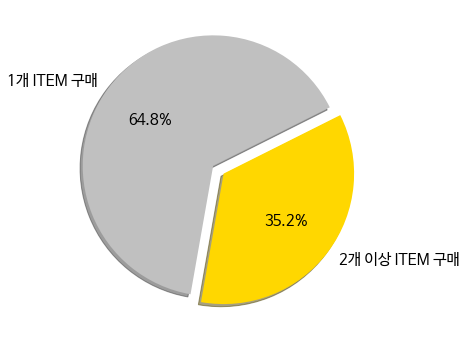

In [ ]:
ratio = []
ratio.append(len(df_final[df_final['INV_AMT'] == df_final['ITEM_AMT']]))
ratio.append(len(df_final[df_final['INV_AMT'] != df_final['ITEM_AMT']]))

labels = ['1개 ITEM 구매', '2개 이상 ITEM 구매']
explode = [0.05, 0.05]
colors = ['silver', 'gold']


plt.figure(figsize=(6,6))
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, explode=explode, shadow=True, colors=colors,textprops={'fontsize': 15})
plt.show()

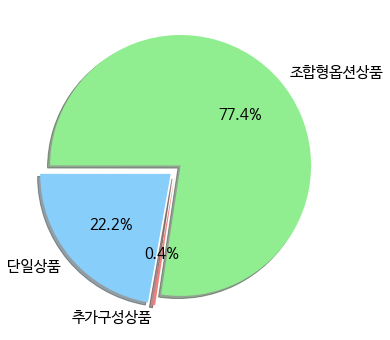

In [ ]:
labels = df_final['BRAND_NM'].unique()

ratio=[]
for i in labels:
    ratio.append(len(df_final[df_final['BRAND_NM']== i]))

explode = [0.05, 0.05, 0.05]
colors = ['lightskyblue', 'lightgreen','lightcoral']


plt.figure(figsize=(6,6))
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, explode=explode, shadow=True, colors=colors,textprops={'fontsize': 15})
plt.show()

In [ ]:
print('데이터 시작일: %s' % df_final['ORDER_CRT_TIME'].min().date())
print('데이터 마지막일: %s' % df_final['ORDER_CRT_TIME'].max().date())

데이터 시작일: 2021-02-24
데이터 마지막일: 2021-06-30


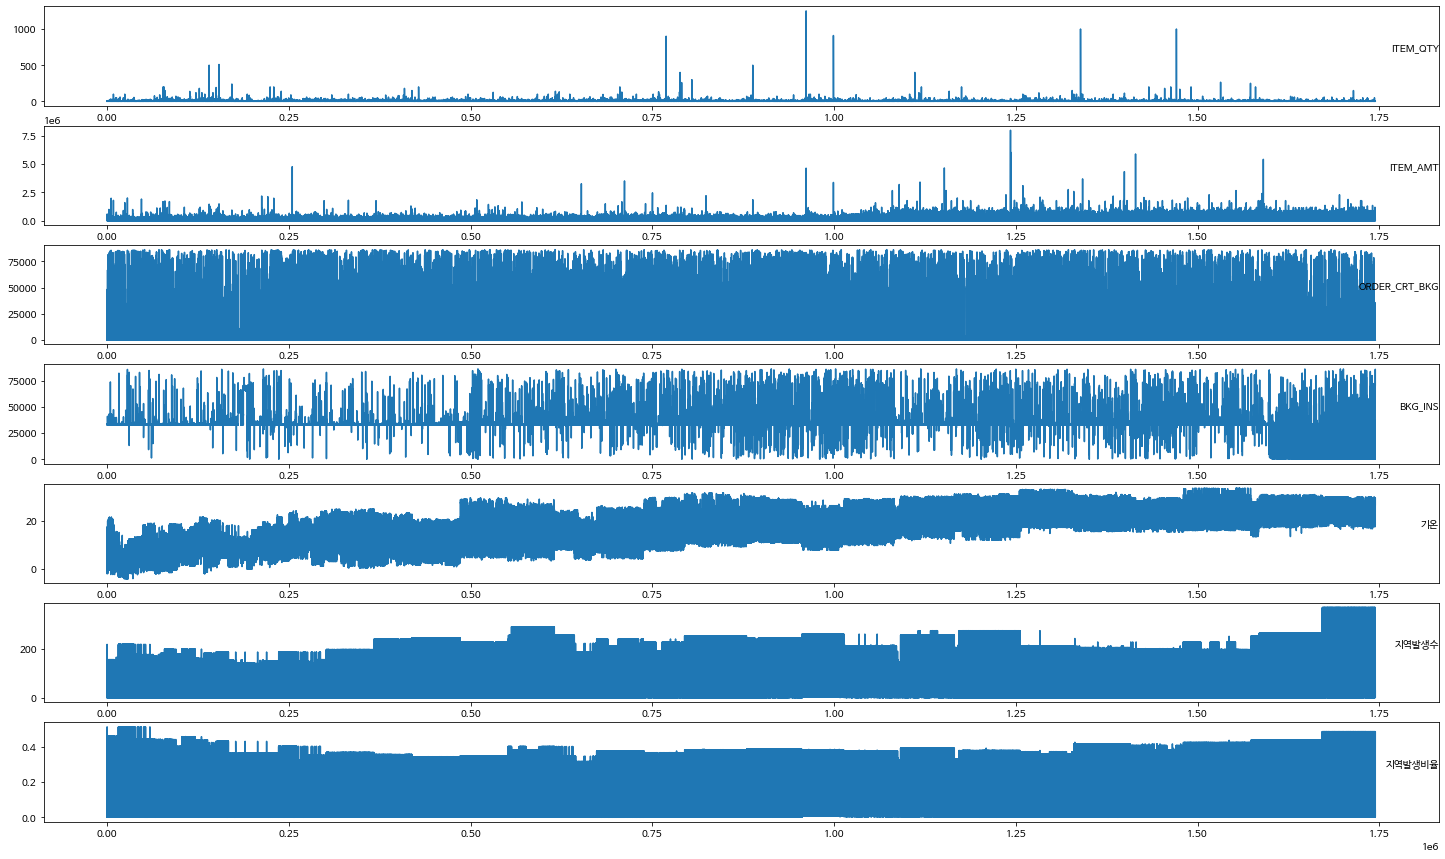

In [ ]:
dataset = pd.concat ([df_final['ORDER_CRT_TIME'],df_final[df_final_continue.columns.tolist()]],axis=1)
dataset = dataset.set_index('ORDER_CRT_TIME')

values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(25,15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right',fontsize=10)
	i += 1
plt.show()

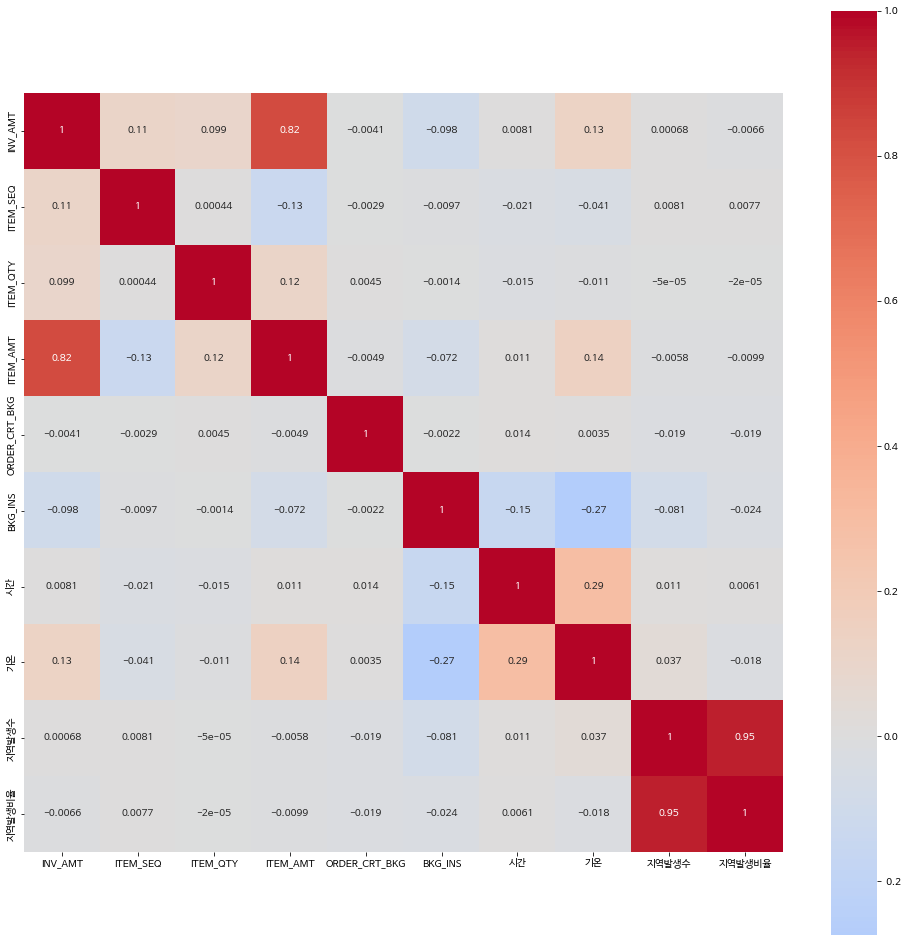

In [ ]:
plt.figure(figsize=(17, 17))
correlations = df_final.corr(method='pearson')

sns.heatmap(correlations, cmap="coolwarm", square=True, center=0, annot=True)

In [ ]:
pd.options.display.float_format = '{:.0f}'.format
df_final_continue = df_final.describe().drop(['INV_AMT','ITEM_SEQ'],axis = 1);df_final_continue

,ITEM_QTY,ITEM_AMT,ORDER_CRT_BKG,BKG_INS,시간,기온,지역발생수,지역발생비율
count,1744406,1744406,1744406,1744406,1744406,1744406,1744406,1744406
mean,1,53843,468,31809,10,17,90,0
std,2,81112,4941,7645,6,7,84,0
min,1,100,0,30,1,-4,0,0
25%,1,15800,6,32992,5,13,12,0
50%,1,24400,8,33168,10,18,48,0
75%,1,59000,18,33346,14,22,161,0
max,1250,7968000,86369,86391,24,34,368,1


## 07) 고객사별 데이터 분류


In [7]:
pivot_qty = pd.pivot_table(df_final,index=['SHPR_CD','ITEM_CD'], values=['ITEM_QTY'],aggfunc='sum')
pivot_qty

ITEM_QTY
SHPR_CD  ITEM_CD               
90001302 1001067355           1
         1001085318           1
         1001240388          16
         1001284113           8
         1001284472          86
...                         ...
90001842 5249264701           1
         5430463324_1         2
         G012_1               1
         G012_3               8
         G014_1               1

[20569 rows x 1 columns]

Text(0, 0.5, 'ITEM_QTY')

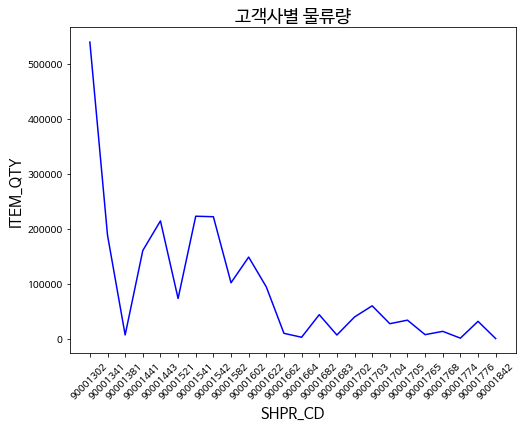

In [7]:
plt.figure(figsize=(8,6))
plt.title('고객사별 물류량', fontsize=18)
plt.plot(pivot_qty.groupby('SHPR_CD').sum(), color='blue')
plt.xlabel('SHPR_CD', fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('ITEM_QTY', fontsize=15)

In [8]:
# 판매량 10000개 이상인 고객사만 추출
df_cust = pivot_qty.groupby('SHPR_CD').sum()
df_cust = df_cust[df_cust['ITEM_QTY'] >= 10000].reset_index();df_cust

,SHPR_CD,ITEM_QTY
0,90001302,539342
1,90001341,188175
2,90001441,160232
3,90001443,214109
4,90001521,73002
5,90001541,222598
6,90001542,221698
7,90001582,101575
8,90001602,148294
9,90001622,94007


In [9]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [10]:
cust_daily_sales = df_final.groupby(['SHPR_CD', 'ORDER_CRT_TIME'], as_index=False)['ITEM_QTY'].sum();cust_daily_sales

,SHPR_CD,ORDER_CRT_TIME,ITEM_QTY
0,90001302,2021-02-24 15:01:27,1
1,90001302,2021-02-24 15:01:45,1
2,90001302,2021-02-24 15:02:43,1
3,90001302,2021-02-24 15:04:16,5
4,90001302,2021-02-24 15:04:47,1
...,...,...,...
1309859,90001842,2021-06-30 15:59:20,1
1309860,90001842,2021-06-30 17:50:23,1
1309861,90001842,2021-06-30 21:23:21,1
1309862,90001842,2021-06-30 21:31:38,5


In [18]:
cust_daily_sales = df_final.groupby(['SHPR_CD', '날짜'], as_index=False)['ITEM_QTY'].sum()

cust_daily_sales_sc = []
for cust in cust_daily_sales['SHPR_CD'].unique():
    current_cust_daily_sales = cust_daily_sales[(cust_daily_sales['SHPR_CD'] == cust)]
    cust_daily_sales_sc.append(go.Scatter(x=current_cust_daily_sales['날짜'], y=current_cust_daily_sales['ITEM_QTY'], name=('고객사 %s' % cust)))

layout = go.Layout(title='고객사별 일일 주문량', xaxis=dict(title='주문 시간'), yaxis=dict(title='주문량'))
fig = go.Figure(data=cust_daily_sales_sc, layout=layout)
iplot(fig)

In [13]:
# 고객사별 데이터 분류
CusNum = len(df_cust['SHPR_CD'].unique())
for i in range(0,CusNum):
    globals()['SHPR_{}'.format(i)] =  df_final[df_final['SHPR_CD'] == (df_final['SHPR_CD'].unique()[i]) ]
    (globals()['SHPR_{}'.format(i)]).reset_index(drop=True,inplace=True)
SHPR_0

,BKG_NO,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,ITEM_QTY,ITEM_AMT,BRAND_NM,날짜,ORDER_CRT_TIME,ORDER_CRT_BKG,BKG_INS,지역,시간,기온,지역발생수,지역발생비율,요일,휴일여부
0,KX007210303370934,90001302,22400.0,2,134265392,1,14900.0,단일상품,2021-03-03,2021-03-03 03:54:59,11,33555,서울,4,-0.4,116,0.272300,수,N
1,KX007210303370935,90001302,14900.0,1,603215395_1,1,14900.0,조합형옵션상품,2021-03-03,2021-03-03 03:55:33,5,33527,부산,4,2.2,8,0.018779,수,N
2,KX007210303370936,90001302,19800.0,1,273205138_4,1,19800.0,조합형옵션상품,2021-03-03,2021-03-03 03:55:35,117,33413,경남,4,0.8,4,0.009390,수,N
3,KX007210303370937,90001302,13350.0,1,4772553980_4,1,13350.0,조합형옵션상품,2021-03-03,2021-03-03 03:56:44,7,33455,충남,4,-1.9,4,0.009390,수,N
4,KX007210303370934,90001302,22400.0,1,228550165,1,7500.0,단일상품,2021-03-03,2021-03-03 03:54:59,11,33555,서울,4,-0.4,116,0.272300,수,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447799,KX007210630601528,90001302,79200.0,2,4328210141_21,1,39600.0,조합형옵션상품,2021-06-30,2021-06-30 08:13:20,5,539,경기,9,24.1,234,0.308300,수,N
447800,KX007210630601530,90001302,42950.0,1,5294687881_14,1,42950.0,조합형옵션상품,2021-06-30,2021-06-30 08:13:49,4,511,경남,9,23.6,16,0.021080,수,N
447801,KX007210630605196,90001302,15600.0,1,288314071,2,15600.0,단일상품,2021-06-30,2021-06-30 09:58:17,21,956,부산,10,26.1,13,0.017128,수,N
447802,KX007210630605418,90001302,11700.0,1,684682148_2,1,11700.0,조합형옵션상품,2021-06-30,2021-06-30 10:12:05,5,2302,경남,11,25.5,16,0.021080,수,N


In [38]:
daily_sales = SHPR_0.groupby('날짜', as_index=False)['ITEM_QTY'].sum()
daily_sales_sc = go.Scatter(x=daily_sales['날짜'], y=daily_sales['ITEM_QTY'])
layout = go.Layout(title='일일 판매량_고객사(90001302)', xaxis=dict(title='날짜'), yaxis=dict(title='수량'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

### --

In [21]:
item_daily_sales = SHPR_0.groupby(['ITEM_CD', '날짜'], as_index=False)['ITEM_QTY'].sum()

In [22]:
item_daily_sales['ITEM_QTY'].describe()

count    101544.000000
mean          5.311412
std          37.363983
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        4924.000000
Name: ITEM_QTY, dtype: float64

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


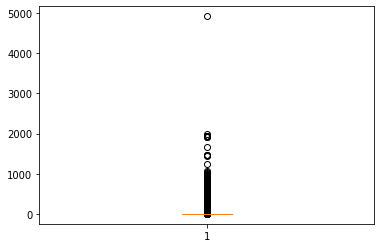

In [23]:
plt.boxplot(item_daily_sales['ITEM_QTY'])
plt.show()

In [24]:
np.percentile(item_daily_sales['ITEM_QTY'], 99.7) # 6 sigma

154.0

In [25]:
item_daily_sales_r = item_daily_sales[item_daily_sales['ITEM_QTY'] <= 154]

In [26]:
freq_item_d_s = item_daily_sales_r.groupby(['ITEM_CD']).count()
items = freq_item_d_s[freq_item_d_s['날짜']>=7].reset_index()['ITEM_CD'].tolist()

item_daily_sales_r['ITEM_CD_SELECT'] = '-1'

for item in items:
    item_daily_sales_r.loc[item_daily_sales_r['ITEM_CD'] == item, 'ITEM_CD_SELECT'] = item

In [27]:
item_daily_sales_r = item_daily_sales_r[item_daily_sales_r['ITEM_CD_SELECT'] != '-1']
item_daily_sales_r = item_daily_sales_r[['ITEM_CD','날짜','ITEM_QTY']];item_daily_sales_r

,ITEM_CD,날짜,ITEM_QTY
2,1001240388,2021-03-14,4
3,1001240388,2021-03-15,1
4,1001240388,2021-03-24,1
5,1001240388,2021-03-25,1
6,1001240388,2021-04-05,1
...,...,...,...
101526,738504037_3,2021-05-21,1
101527,738504037_3,2021-05-24,1
101528,738504037_3,2021-05-28,1
101529,738504037_3,2021-06-09,1


In [28]:
item_daily_sales = item_daily_sales_r
item10 = item_daily_sales.sort_values(by=['ITEM_QTY'], axis=0,ascending=False)[:10]['ITEM_CD']
item_daily_sales_sc = []
for item in item10:
    current_item_daily_sales = item_daily_sales[(item_daily_sales['ITEM_CD'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['날짜'], y=current_item_daily_sales['ITEM_QTY'], name=('아이템 %s' % item)))

layout = go.Layout(title='고객사(90001302) 일일 주문량', xaxis=dict(title='날짜'), yaxis=dict(title='주문량'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

In [29]:
item_daily_sales.describe()

,ITEM_QTY
count,95198.000000
mean,3.819208
std,6.999819
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,154.000000


### --

In [31]:
# train,test 분리
df_train = SHPR_0.loc[SHPR_0['ORDER_CRT_TIME'] < '2021-06-01',:]
df_test = SHPR_0.loc[SHPR_0['ORDER_CRT_TIME'] >= '2021-06-01',:]
print('Min date from train set: %s' % df_train['ORDER_CRT_TIME'].min().date())
print('Max date from train set: %s' % df_train['ORDER_CRT_TIME'].max().date())
print('Min date from test set: %s' % df_test['ORDER_CRT_TIME'].min().date())
print('Max date from test set: %s' % df_test['ORDER_CRT_TIME'].max().date())

Min date from train set: 2021-02-24
Max date from train set: 2021-05-31
Min date from test set: 2021-06-01
Max date from test set: 2021-06-30


In [32]:
print(df_train.shape,df_test.shape)

(321227, 19) (126577, 19)


In [45]:
lag_size = (df_test['ORDER_CRT_TIME'].max().date() - df_train['ORDER_CRT_TIME'].max().date()).days

## 09) 예측 모델링
- train/test 데이터 분리

In [36]:
df_train_r = df_train[df_train['ITEM_QTY'] <= 154]

freq_item_d_s = df_train_r.groupby(['ITEM_CD']).count()
items = freq_item_d_s[freq_item_d_s['날짜']>=7].reset_index()['ITEM_CD'].tolist()

df_train_r['ITEM_CD_SELECT'] = '-1'

for item in items:
    df_train_r.loc[df_train_r['ITEM_CD'] == item, 'ITEM_CD_SELECT'] = item
df_train_r

,BKG_NO,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,ITEM_QTY,ITEM_AMT,BRAND_NM,날짜,ORDER_CRT_TIME,ORDER_CRT_BKG,BKG_INS,지역,시간,기온,지역발생수,지역발생비율,요일,휴일여부,ITEM_CD_SELECT
0,KX007210303370934,90001302,22400.0,2,134265392,1,14900.0,단일상품,2021-03-03,2021-03-03 03:54:59,11,33555,서울,4,-0.4,116,0.272300,수,N,134265392
1,KX007210303370935,90001302,14900.0,1,603215395_1,1,14900.0,조합형옵션상품,2021-03-03,2021-03-03 03:55:33,5,33527,부산,4,2.2,8,0.018779,수,N,603215395_1
2,KX007210303370936,90001302,19800.0,1,273205138_4,1,19800.0,조합형옵션상품,2021-03-03,2021-03-03 03:55:35,117,33413,경남,4,0.8,4,0.009390,수,N,273205138_4
3,KX007210303370937,90001302,13350.0,1,4772553980_4,1,13350.0,조합형옵션상품,2021-03-03,2021-03-03 03:56:44,7,33455,충남,4,-1.9,4,0.009390,수,N,4772553980_4
4,KX007210303370934,90001302,22400.0,1,228550165,1,7500.0,단일상품,2021-03-03,2021-03-03 03:54:59,11,33555,서울,4,-0.4,116,0.272300,수,N,228550165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326346,KX007210601890882,90001302,11900.0,1,4742636644_1,1,11900.0,조합형옵션상품,2021-05-31,2021-05-31 18:05:37,50255,33527,전북,19,24.3,9,0.021898,월,N,4742636644_1
326863,KX007210601892087,90001302,24000.0,1,4949580467_3,1,24000.0,조합형옵션상품,2021-05-31,2021-05-31 23:44:42,35609,33076,세종,24,17.3,3,0.007299,월,N,4949580467_3
329033,KX007210602920583,90001302,51800.0,1,308108017_6,2,51800.0,조합형옵션상품,2021-05-31,2021-05-31 08:16:17,2001,33146,경기,9,18.5,127,0.309002,월,N,308108017_6
329292,KX007210601897201,90001302,21300.0,1,5526940648_5,1,21300.0,조합형옵션상품,2021-05-30,2021-05-30 10:01:44,13612,33194,광주,11,25.3,9,0.019397,일,Y,5526940648_5


In [49]:
df_train =df_train_r
df_train.sort_values('날짜').groupby(['ITEM_CD', 'SHPR_CD','날짜'], as_index=False).agg({'ITEM_QTY':['mean']})

,ITEM_CD,SHPR_CD,날짜,ITEM_QTY
,,,,mean
0,1001067355,90001302,2021-04-21,1.0
1,1001085318,90001302,2021-03-27,1.0
2,1001240388,90001302,2021-03-14,2.0
3,1001240388,90001302,2021-03-15,1.0
4,1001240388,90001302,2021-03-24,1.0
...,...,...,...,...
74359,741582411_1,90001302,2021-05-28,2.0
74360,741582411_1,90001302,2021-05-31,1.0
74361,741582411_2,90001302,2021-05-17,1.0


In [60]:
train_gp = df_train.sort_values('ORDER_CRT_TIME').groupby(['ITEM_CD','SHPR_CD','날짜'], as_index=False)
train_gp = train_gp.agg({'ITEM_QTY':['mean']})
train_gp.columns = ['item', 'cust', 'date', 'item_qty']
train_gp.head()

,item,cust,date,item_qty
0,1001067355,90001302,2021-04-21,1.0
1,1001085318,90001302,2021-03-27,1.0
2,1001240388,90001302,2021-03-14,2.0
3,1001240388,90001302,2021-03-15,1.0
4,1001240388,90001302,2021-03-24,1.0


In [53]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [61]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),cust(t-29),item_qty(t-29),item(t-28),cust(t-28),item_qty(t-28),item(t-27),cust(t-27),item_qty(t-27),item(t-26),cust(t-26),item_qty(t-26),item(t-25),cust(t-25),item_qty(t-25),item(t-24),cust(t-24),item_qty(t-24),item(t-23),cust(t-23),item_qty(t-23),item(t-22),cust(t-22),item_qty(t-22),item(t-21),cust(t-21),item_qty(t-21),item(t-20),cust(t-20),item_qty(t-20),item(t-19),cust(t-19),item_qty(t-19),item(t-18),cust(t-18),item_qty(t-18),item(t-17),cust(t-17),item_qty(t-17),item(t-16),...,item_qty(t-12),item(t-11),cust(t-11),item_qty(t-11),item(t-10),cust(t-10),item_qty(t-10),item(t-9),cust(t-9),item_qty(t-9),item(t-8),cust(t-8),item_qty(t-8),item(t-7),cust(t-7),item_qty(t-7),item(t-6),cust(t-6),item_qty(t-6),item(t-5),cust(t-5),item_qty(t-5),item(t-4),cust(t-4),item_qty(t-4),item(t-3),cust(t-3),item_qty(t-3),item(t-2),cust(t-2),item_qty(t-2),item(t-1),cust(t-1),item_qty(t-1),item(t),cust(t),item_qty(t),item(t+30),cust(t+30),item_qty(t+30)
29,1001067355,90001302,1.0,1001085318,90001302,1.0,1001240388,90001302,2.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,3.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001284113,...,2.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0
30,1001085318,90001302,1.0,1001240388,90001302,2.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,3.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001284113,90001302,1.5,1001284113,...,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,3.0,1001284472,90001302,1.0
31,1001240388,90001302,2.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,3.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001284113,90001302,1.5,1001284113,90001302,2.0,1001284113,...,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,3.0,1001284472,90001302,1.0,1001303172,90001302,1.0
32,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,3.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001284113,90001302,1.5,1001284113,90001302,2.0,1001284113,90001302,2.0,1001284113,...,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,3.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001429503,90001302,1.0
33,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,3.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001240388,90001302,1.0,1001284113,90001302,1.5,1001284113,90001302,2.0,1001284113,90001302,2.0,1001284113,90001302,1.0,1001284472,...,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,1001284472,90001302,1.0,10012

In [62]:
last_item = 'item(t-%d)' % window
last_cust = 'cust(t-%d)' % window
series = series[(series['cust(t)'] == series[last_cust])]
series = series[(series['item(t)'] == series[last_item])]

In [63]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'cust']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'cust']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'cust(t)'], axis=1, inplace=True)

In [64]:
# Label
labels_col = 'item_qty(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (12924, 30)
Validation set shape (8616, 30)


,item_qty(t-29),item_qty(t-28),item_qty(t-27),item_qty(t-26),item_qty(t-25),item_qty(t-24),item_qty(t-23),item_qty(t-22),item_qty(t-21),item_qty(t-20),item_qty(t-19),item_qty(t-18),item_qty(t-17),item_qty(t-16),item_qty(t-15),item_qty(t-14),item_qty(t-13),item_qty(t-12),item_qty(t-11),item_qty(t-10),item_qty(t-9),item_qty(t-8),item_qty(t-7),item_qty(t-6),item_qty(t-5),item_qty(t-4),item_qty(t-3),item_qty(t-2),item_qty(t-1),item_qty(t)
26251,1.0,1.000000,1.000000,1.0,1.000000,1.000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0000,1.000000,1.0,1.000000,1.0,1.0,1.0,1.00,1.000000,1.0,1.000000,1.00,1.000000,1.000000,1.000000,1.0,1.0,1.0
26314,1.0,1.000000,1.000000,1.0,1.000000,1.000,1.0,1.500000,1.0,1.000000,1.000000,2.000000,1.0000,1.000000,1.0,1.000000,1.0,1.5,1.0,1.00,1.000000,1.0,1.000000,1.00,1.000000,1.666667,2.000000,1.0,1.0,1.0
16825,2.0,3.333333,2.714286,1.0,1.000000,1.375,1.5,1.666667,4.0,2.666667,2.333333,2.285714,1.7000,1.444444,1.4,1.666667,2.0,1.5,1.0,2.50,2.200000,3.5,2.250000,1.75,1.666667,5.000000,1.272727,2.0,4.0,3.0
72191,1.0,1.666667,1.000000,1.0,1.111111,1.000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0625,1.000000,1.0,1.000000,1.0,1.0,1.0,1.00,1.000000,1.0,1.000000,1.00,1.000000,1.000000,1.000000,1.0,1.0,1.0
36550,1.0,1.000000,1.000000,1.0,1.000000,1.000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0000,1.000000,1.0,1.000000,1.0,1.0,1.0,1.25,1.222222,1.0,1.333333,1.00,1.000000,1.000000,1.000000,1.0,1.0,1.0


### MLP

In [65]:
epochs = 40
batch = 256
lr = 0.0003
adam = tf.keras.optimizers.Adam(lr)

In [66]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3100      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [67]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
404/404 - 2s - loss: 2.6803 - val_loss: 3.1253 - 2s/epoch - 5ms/step
Epoch 2/40
404/404 - 1s - loss: 2.1534 - val_loss: 3.0009 - 820ms/epoch - 2ms/step
Epoch 3/40
404/404 - 1s - loss: 2.0584 - val_loss: 2.9658 - 854ms/epoch - 2ms/step
Epoch 4/40
404/404 - 1s - loss: 2.0190 - val_loss: 2.9827 - 751ms/epoch - 2ms/step
Epoch 5/40
404/404 - 1s - loss: 1.9996 - val_loss: 2.9789 - 854ms/epoch - 2ms/step
Epoch 6/40
404/404 - 1s - loss: 1.9794 - val_loss: 2.9740 - 758ms/epoch - 2ms/step
Epoch 7/40
404/404 - 1s - loss: 1.9613 - val_loss: 2.9020 - 731ms/epoch - 2ms/step
Epoch 8/40
404/404 - 1s - loss: 1.9459 - val_loss: 2.9404 - 757ms/epoch - 2ms/step
Epoch 9/40
404/404 - 1s - loss: 1.9350 - val_loss: 2.9446 - 760ms/epoch - 2ms/step
Epoch 10/40
404/404 - 1s - loss: 1.9126 - val_loss: 2.9059 - 801ms/epoch - 2ms/step
Epoch 11/40
404/404 - 1s - loss: 1.9019 - val_loss: 2.9150 - 737ms/epoch - 2ms/step
Epoch 12/40
404/404 - 1s - loss: 1.8971 - val_loss: 2.9053 - 811ms/epoch - 2ms/step
Epoc

### cnn

In [68]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (12924, 30, 1)
Validation set shape (8616, 30, 1)


In [69]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                44850     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 45,093
Trainable params: 45,093
Non-trainable params: 0
__________________________________________________

In [70]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
404/404 - 2s - loss: 2.1674 - val_loss: 2.9489 - 2s/epoch - 5ms/step
Epoch 2/40
404/404 - 2s - loss: 2.0128 - val_loss: 2.9215 - 2s/epoch - 4ms/step
Epoch 3/40
404/404 - 2s - loss: 1.9946 - val_loss: 2.9204 - 2s/epoch - 4ms/step
Epoch 4/40
404/404 - 1s - loss: 1.9864 - val_loss: 2.9833 - 1s/epoch - 3ms/step
Epoch 5/40
404/404 - 1s - loss: 1.9809 - val_loss: 2.9890 - 1s/epoch - 3ms/step
Epoch 6/40
404/404 - 1s - loss: 1.9770 - val_loss: 2.9793 - 1s/epoch - 3ms/step
Epoch 7/40
404/404 - 1s - loss: 1.9706 - val_loss: 2.9697 - 1s/epoch - 3ms/step
Epoch 8/40
404/404 - 1s - loss: 1.9624 - val_loss: 2.9860 - 1s/epoch - 3ms/step
Epoch 9/40
404/404 - 1s - loss: 1.9622 - val_loss: 2.9965 - 1s/epoch - 3ms/step
Epoch 10/40
404/404 - 1s - loss: 1.9523 - val_loss: 3.0077 - 1s/epoch - 3ms/step
Epoch 11/40
404/404 - 1s - loss: 1.9441 - val_loss: 2.9567 - 1s/epoch - 3ms/step
Epoch 12/40
404/404 - 2s - loss: 1.9436 - val_loss: 2.9814 - 2s/epoch - 4ms/step
Epoch 13/40
404/404 - 1s - loss: 1.93

### LSTM

In [71]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [72]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
404/404 - 8s - loss: 18.8189 - val_loss: 2.9079 - 8s/epoch - 19ms/step
Epoch 2/40
404/404 - 6s - loss: 2.0029 - val_loss: 2.8948 - 6s/epoch - 16ms/step
Epoch 3/40
404/404 - 6s - loss: 1.9964 - val_loss: 2.8943 - 6s/epoch - 15ms/step
Epoch 4/40
404/404 - 6s - loss: 1.9911 - val_loss: 2.9132 - 6s/epoch - 15ms/step
Epoch 5/40
404/404 - 6s - loss: 1.9934 - val_loss: 2.9136 - 6s/epoch - 16ms/step
Epoch 6/40
404/404 - 6s - loss: 1.9901 - val_loss: 2.8988 - 6s/epoch - 15ms/step
Epoch 7/40
404/404 - 6s - loss: 1.9901 - val_loss: 2.8997 - 6s/epoch - 15ms/step
Epoch 8/40
404/404 - 6s - loss: 1.9898 - val_loss: 2.9282 - 6s/epoch - 15ms/step
Epoch 9/40
404/404 - 6s - loss: 1.9899 - val_loss: 2.9143 - 6s/epoch - 15ms/step
Epoch 10/40
404/404 - 6s - loss: 1.9902 - val_loss: 2.9198 - 6s/epoch - 15ms/step
Epoch 11/40
404/404 - 6s - loss: 1.9855 - val_loss: 2.8892 - 6s/epoch - 15ms/step
Epoch 12/40
404/404 - 6s - loss: 1.9844 - val_loss: 2.9053 - 6s/epoch - 16ms/step
Epoch 13/40
404/404 - 6s

### CNN-LSTM

In [73]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (12924, 2, 15, 1)
Validation set shape (8616, 2, 15, 1)


In [74]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [75]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
404/404 - 4s - loss: 2.0832 - val_loss: 3.0260 - 4s/epoch - 10ms/step
Epoch 2/40
404/404 - 3s - loss: 2.0035 - val_loss: 2.9143 - 3s/epoch - 6ms/step
Epoch 3/40
404/404 - 2s - loss: 1.9938 - val_loss: 2.9976 - 2s/epoch - 6ms/step
Epoch 4/40
404/404 - 2s - loss: 1.9744 - val_loss: 3.0681 - 2s/epoch - 6ms/step
Epoch 5/40
404/404 - 2s - loss: 1.9736 - val_loss: 3.0802 - 2s/epoch - 6ms/step
Epoch 6/40
404/404 - 2s - loss: 1.9648 - val_loss: 3.0920 - 2s/epoch - 6ms/step
Epoch 7/40
404/404 - 3s - loss: 1.9604 - val_loss: 3.0609 - 3s/epoch - 6ms/step
Epoch 8/40
404/404 - 2s - loss: 1.9394 - val_loss: 3.1135 - 2s/epoch - 6ms/step
Epoch 9/40
404/404 - 3s - loss: 1.9395 - val_loss: 3.0839 - 3s/epoch - 7ms/step
Epoch 10/40
404/404 - 2s - loss: 1.9210 - val_loss: 3.1568 - 2s/epoch - 6ms/step
Epoch 11/40
404/404 - 2s - loss: 1.9075 - val_loss: 3.1160 - 2s/epoch - 6ms/step
Epoch 12/40
404/404 - 2s - loss: 1.8964 - val_loss: 3.1094 - 2s/epoch - 6ms/step
Epoch 13/40
404/404 - 2s - loss: 1.8

### 모델 비교

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


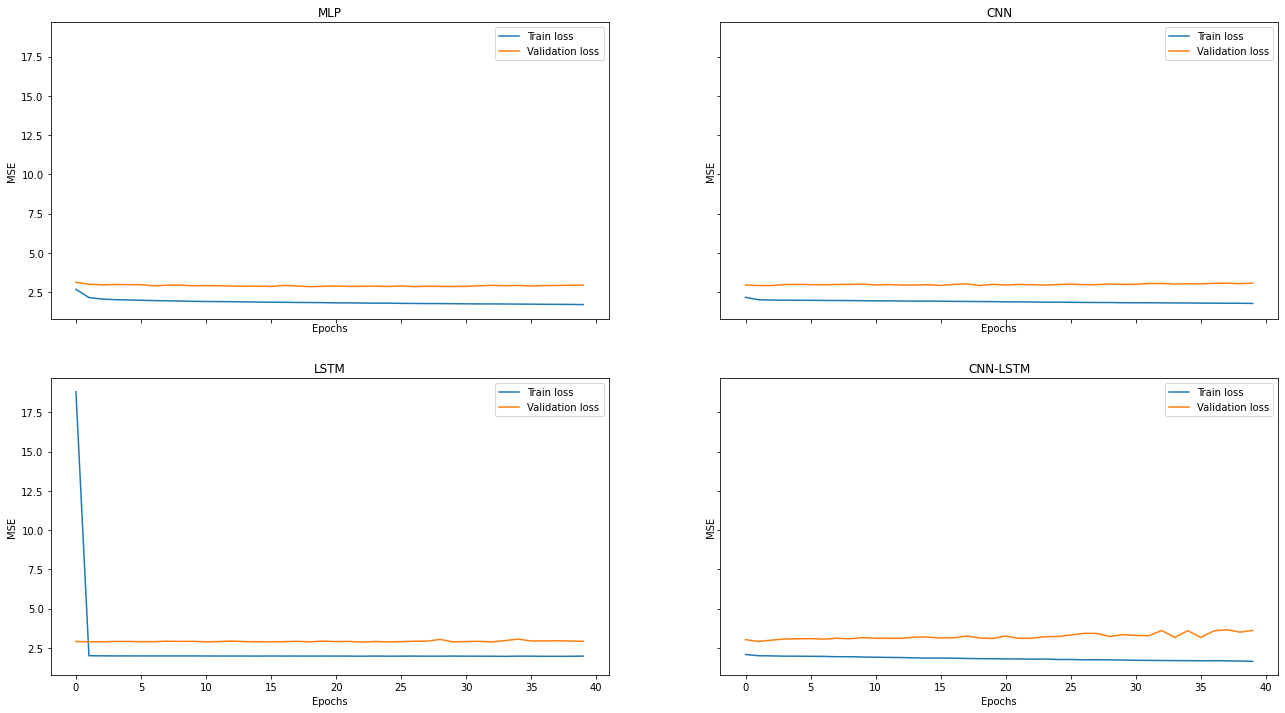

In [76]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

In [77]:
# MLP
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

Train rmse: 1.2982780765289341
Validation rmse: 1.7146908649661337


In [78]:
# CNN
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 1.326183962490449
Validation rmse: 1.7535316249128579


In [79]:
# LSTM
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

Train rmse: 1.4041929906164117
Validation rmse: 1.7535316249128579


In [80]:
# CNN_LSTM
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

Train rmse: 1.2729274476673684
Validation rmse: 1.9009386292215869


loss값이 제일 작은 MLP 모델 선택